In [1]:
import galsim
import batsim
import numpy as np
import numpy.lib.recfunctions as rfn
import matplotlib
import matplotlib.pyplot as plt
import anacal
import fpfs
import glob
from time import time
from astropy.visualization import simple_norm

from tqdm import tqdm, trange

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

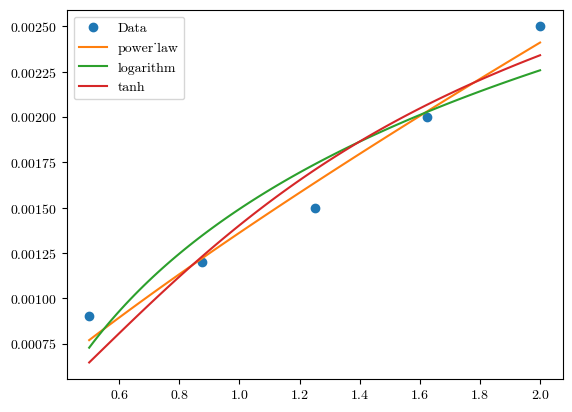

In [2]:
from scipy.optimize import curve_fit

hlr = 0.08
rwf_extend = np.linspace(0.5, 2, 100)
rwf = np.linspace(0.5,2.0,5)

A = [0.0009, 0.0012, 0.0015, 0.002, 0.0025]

def power_law(rwf, m, b):
    return m * rwf**b

def logarithm(rwf, m, b):
    return m * np.log(rwf) + b

def tanh(rwf, m, b):
    return m * rwf**b * np.tanh(rwf)

funcs = [power_law, logarithm, tanh]
plt.figure()
plt.plot(rwf, A, 'o', label='Data')
for func in funcs:
    popt, pcov = curve_fit(func, rwf, A)
    plt.plot(rwf_extend, func(rwf_extend, *popt), label=f'{func.__name__}')

plt.legend()

In [3]:
def cancel_shape_noise(gal_obj, nrot):
    '''Create nrot rotated versions of the input galaxy object
    such that shape noise cancels out when averaging the shapes'''
    rotated_gals = []
    for i in range(nrot):
        rot_ang = np.pi / nrot * i
        ang = rot_ang * galsim.radians
        gal_obj = gal_obj.rotate(ang)
        rotated_gals.append(gal_obj)
        
    return rotated_gals

In [22]:
cosmos = galsim.COSMOSCatalog()
records = cosmos.getParametricRecord(index=np.arange(len(cosmos)))

sim_dir = 'simulations/isolated_noiseless'
file_list = glob.glob(sim_dir + '/*.fits')
rands = np.random.choice(len(file_list), 1024, replace=False)
file_list = [file_list[i] for i in rands]

idents = [int(f.split('/COSMOS_')[-1].split('_')[0]) for f in file_list]
#idents = [1189362, 53269, 159123, 173920]

# Create LSST-like PSF
seeing = 0.67
psf = galsim.Moffat(beta=3.5, fwhm=seeing, trunc=seeing*4)

nn = 64
scale = 0.2
n_rot = 4
# Total size of stamp for 4 galaxies
stamp_size = int(nn * np.sqrt(n_rot))

#### KEY THING TO CHANGE ####
clip_rad = 5

hlrs = []
gal_list = []
for i,ident in tqdm(enumerate(idents)):

    record_ind = np.where(records['IDENT'] == ident)[0][0]
    gal = cosmos.makeGalaxy(index=record_ind, gal_type='parametric')

        # Get HLR for galaxy to create IA transform
    if records['use_bulgefit'][record_ind]:
        hlr = records['hlr'][record_ind][2]
    else:
        hlr = records['hlr'][record_ind][0]
    hlrs.append(hlr)

    # Create IA transform
    IATransform = batsim.IaTransform(
        scale=scale,
        hlr=hlr,
        A=0.00136207,
        beta=0.82404653, # best fit Georgiou19+
        phi = np.radians(0),
        clip_radius=clip_rad # clip the transform at 5*hlr to prevent edge effects
        #tidal_suppresion=1 # Suppres shear according to an inverse square law
    )

    # Create rotated versions of the galaxy
    rotated_gals = cancel_shape_noise(gal, n_rot)
    stamp = galsim.ImageF(stamp_size, stamp_size, scale=scale)
    for j in range(n_rot):

        # set drawing location on image
        row = j // int(np.sqrt(1*n_rot))
        col = j % int(np.sqrt(1*n_rot))

        # Compute the bounds for this galaxy
        xmin = col * nn + 1  # +1 because GalSim coordinates start at 1
        xmax = (col + 1) * nn
        ymin = row * nn + 1
        ymax = (row + 1) * nn

        #Convolve with PSF and pixel response
        gal_img = batsim.simulate_galaxy(
            ngrid=nn,
            pix_scale=scale,
            gal_obj=rotated_gals[j],
            transform_obj=IATransform,
            psf_obj=psf,
            draw_method="auto"
        )

        # Set the subimage in the stamp
        bounds = galsim.BoundsI(xmin, xmax, ymin, ymax)
        sub_image = galsim.Image(gal_img, scale=scale)
        stamp.setSubImage(bounds, sub_image)

    gal_list.append(stamp.array)

    if i == 0:
        gal_array = stamp.array
        gal_scene = gal_array
    else:
        gal_array = stamp.array
        gal_scene = np.concatenate((gal_scene, gal_array), axis=1)

0it [00:00, ?it/s]/home/b7009348/.local/lib/python3.11/site-packages/batsim/transforms.py:117: UserWarning: Clip radii less than 5 may truncate shear within the galaxy itself.
  warnings.warn("Clip radii less than 5 may truncate shear within the galaxy itself.")
1024it [1:13:04,  4.28s/it]


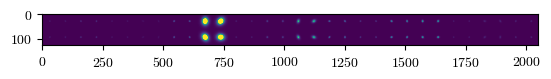

In [5]:
norm = matplotlib.colors.Normalize(vmin=gal_scene.min(), vmax=gal_scene.max()/10)
plt.imshow(gal_scene, norm=norm, cmap='viridis')

In [6]:
ngals = len(idents)
scene_nx = gal_scene.shape[0]
scene_ny = gal_scene.shape[1]
nn = scene_ny // (2*ngals)

a_ia = galsim.Shear(e1=0.00136207, e2=0).g1
b_ia = 0.82404653
print(scale, scene_nx, scene_ny, nn, a_ia)

0.2 128 2048 64 0.0006810353158702314


In [7]:
rcut = 16
psf_data = psf.shift(0.5*scale, 0.5*scale).drawImage(nx=nn, ny=nn, scale=scale, method='auto')
rpp = psf.scale_radius
beta_max = 0.99*rpp
print(rpp, beta_max)

0.7158288724217481 0.7086705836975306


In [8]:
# FPFS measurement function
def test_kernel_size(sigma_arcsec, psf_arr, gal_scene, scale, nx, ny, true_shear=None, get_mms=False):

    # initialize FPFS shear measurement task
    fpTask = fpfs.image.measure_source(psf_arr, sigma_arcsec=sigma_arcsec, pix_scale=scale)

    scene_nx = gal_scene.shape[0]
    scene_ny = gal_scene.shape[1]
    
    # force detection in specific order 
    indX = np.arange(int(nx/2), scene_nx, nx)
    indY = np.arange(int(ny/2), scene_ny, ny)
    inds = np.meshgrid(indY, indX, indexing="ij")
    coords = np.vstack([np.ravel(_) for _ in inds]).T
    coords = np.flip(coords, axis=1)    

    # measure shear with FPFS on entire scene
    mms = fpTask.measure(gal_scene, coords)
    mms = fpTask.get_results(mms)

    # convert momemnts to ellipticity estimates
    ells = fpfs.catalog.fpfs_m2e(mms, const=2000)
    resp = np.average(ells['fpfs_R1E'])
    shear = np.average(ells['fpfs_e1'])/resp

    if true_shear is not None:
        m_bias = abs(shear - true_shear)/true_shear
        if get_mms:
            return coords, shear, m_bias, ells, mms
        else:
            return coords, shear, m_bias, ells
    
    if get_mms:
        return coords, shear, ells, mms
    else:
        return coords, shear, ells

In [9]:
kernels = np.linspace(0.3, beta_max, 20)
rwfs = np.zeros((len(kernels), ngals))
sample_shears = np.zeros(len(kernels))
per_gal_shear = np.zeros((len(kernels), ngals))
for i in trange(len(kernels)):
    coords, shear, ells = test_kernel_size(
                                kernels[i],
                                psf_data.array,
                                gal_scene,
                                scale,
                                nn,
                                nn
                            )

    sample_shears[i] = shear

    for j in range(ngals):
        max_ind = 4*(j+1)
        min_ind = j*4
        shear = np.average(ells[min_ind:max_ind]['fpfs_e1']) 
        resp = np.average(ells[min_ind:max_ind]['fpfs_R1E'])

        shear /= resp
        per_gal_shear[i,j] = shear
        a_rwf = galsim.Shear(g1=shear).e1
        rwfs[i,j] = (a_rwf / a_ia) ** (1/b_ia)

  0%|          | 0/20 [00:00<?, ?it/s]2024/06/27 13:35:00 ---  Unable to initialize backend 'cuda': 
2024/06/27 13:35:00 ---  Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024/06/27 13:35:00 ---  Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024/06/27 13:35:01 ---  Order of the shear estimator: nnord=4
2024/06/27 13:35:01 ---  Shapelet kernel in configuration space: sigma= 0.3000 arcsec
2024/06/27 13:35:01 ---  Detection kernel in configuration space: sigma= 0.3000 arcsec
2024/06/27 13:35:02 ---  Maximum |k| is 3.043
  5%|▌         | 1/20 [00:03<01:14,  3.93s/it]2024/06/27 13:35:04 ---  Order of the shear estimator: nnord=4
2024/06/27 13:35:04 ---  Shapelet kernel in configuration space: sigma= 0.3215 arcsec
2024/06/27 13:35:04 ---  Detection kernel in configuration space: sigma= 0.3215 arcsec
2024/06/27 13:35:04 ---  Maximum |k| is

Text(0, 0.5, 'Half Light Radius (arcsec)')

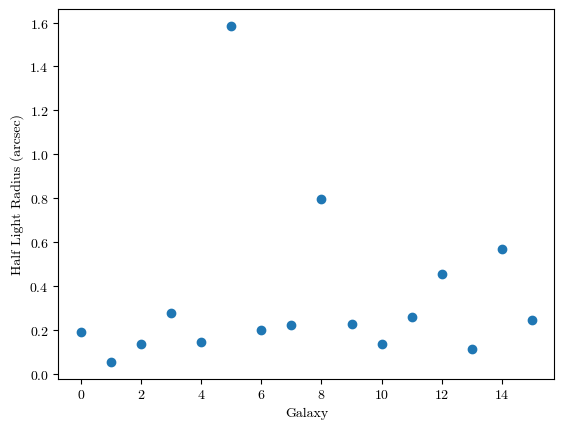

In [21]:
# Plot half light radii of galaxies
plt.figure()
plt.scatter(np.arange(ngals), hlrs)
plt.xlabel('Galaxy')
plt.ylabel('Half Light Radius (arcsec)')

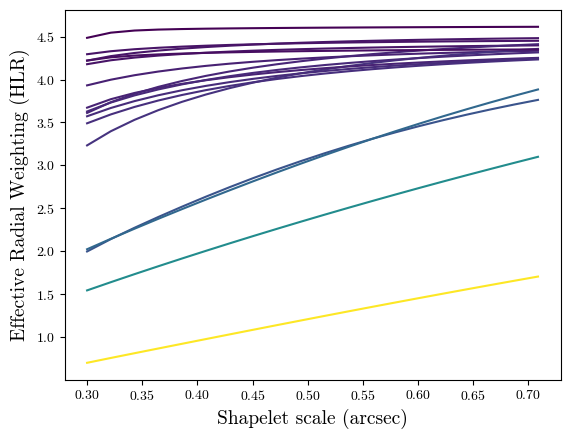

In [10]:
minima = min(hlrs)
maxima = max(hlrs)

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.viridis)

plt.figure()
for i in range(len(idents)):
    plt.plot(kernels, rwfs[:,i],c=mapper.to_rgba(hlrs[i]), label=f'Galaxy {idents[i]}, HLR={hlrs[i]:.2f}')
#plt.legend(fontsize=12)
plt.xlabel('Shapelet scale (arcsec)', fontsize=14)
plt.ylabel('Effective Radial Weighting (HLR)', fontsize=14)
#plt.title('Shear truncation {:.2f} half light radii'.format(clip_rad))

plt.savefig('no_truncation.pdf', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Shear truncation 5.00 half light radii')

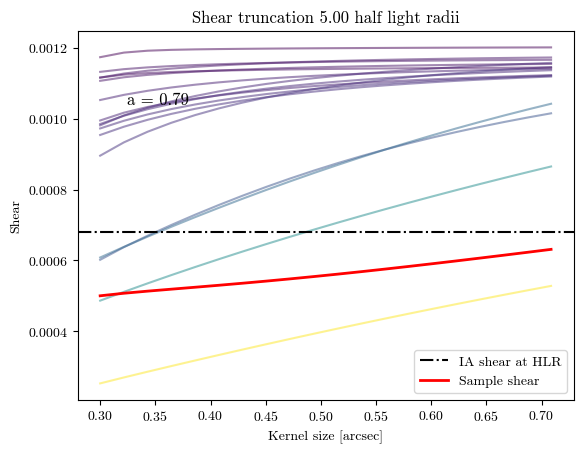

In [11]:
for i in range(len(idents)):
    plt.plot(kernels, per_gal_shear[:,i], c=mapper.to_rgba(hlrs[i]), ls='-', alpha=0.5)
plt.axhline(a_ia, color='black', linestyle='-.', label='IA shear at HLR')

plt.plot(kernels, sample_shears, label='Sample shear', linestyle='-', color='red', lw=2)

a = sample_shears[0] / sample_shears[-1]

plt.text(0.1, 0.8, f'a = {a:.2f}', fontsize=12, transform=plt.gca().transAxes)

plt.legend()
plt.xlabel('Kernel size [arcsec]')
plt.ylabel('Shear')
plt.title('Shear truncation {:.2f} half light radii'.format(clip_rad))

# NEED TO EXTEND IA MODEL TO ENSURE SHEAR DOESN'T GET HUGE IN SMALL DIFFUSE GALAXIES

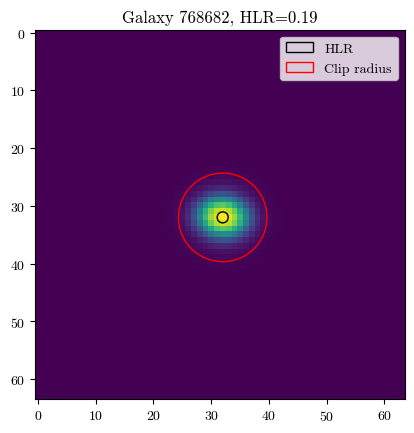

In [13]:
i = 0
norm = simple_norm(gal_list[i][:nn,:nn], 'asinh')
plt.imshow(gal_list[i][:nn,:nn], cmap='viridis', norm=norm)
plt.title(f'Galaxy {idents[i]}, HLR={hlrs[i]:.2f}')
hlr_pix = hlrs[i] / scale

# plot the HLR of the galaxy
plt.gca().add_artist(plt.Circle((nn//2, nn//2), hlr_pix, color='black', fill=False, label='HLR'))
plt.gca().add_artist(plt.Circle((nn//2, nn//2), 8*hlr_pix, color='red', fill=False, label='Clip radius'))
plt.legend()

In [14]:
# Calculate the isophote radii for 25, 50, 75% of the light
cut = np.percentile(gal_list[i][:64,:64], 100)
print(cut)

0.08259757608175278


### Try truncate image rather than change kernel size


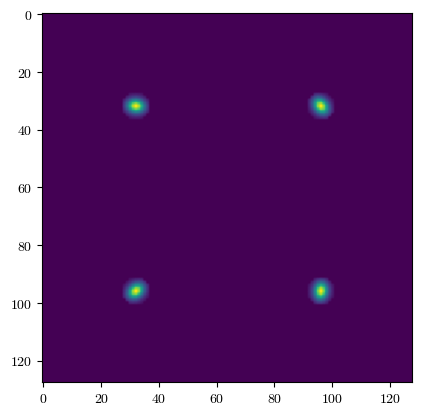

In [15]:
i = 0

def truncate_image(image, hlr, nx, ny, scale, trunc_rad):
    hlr_pix = hlr / scale
    trunc_rad = trunc_rad*hlr_pix
    x, y = np.meshgrid(np.arange(nx) - nx//2, np.arange(ny) - ny//2)
    radii = np.sqrt((x * scale)**2 + (y * scale)**2)
    mask = (radii <= trunc_rad).astype(float)
    mask = np.tile(mask, (2, 2))
    image_trunc = image * mask
    return image_trunc

gal_trunc = truncate_image(gal_list[i], hlrs[i], nx=nn, ny=nn, scale=scale, trunc_rad=1)

plt.figure()
plt.imshow(gal_trunc, cmap='viridis')


In [16]:
trunc_radii = np.linspace(1, 5, 20)
rwfs = np.zeros((len(trunc_radii), ngals))
sample_shears = np.zeros(len(trunc_radii))
per_gal_shear = np.zeros((len(trunc_radii), ngals))

for i, trunc_rad in tqdm(enumerate(trunc_radii)):

    for j, gal in enumerate(gal_list):

        gal_trunc = truncate_image(gal, hlrs[j], nx=nn, ny=nn, scale=scale, trunc_rad=trunc_rad)

        if j == 0:
            trunc_scene = gal_trunc
        else:
            trunc_scene = np.concatenate((trunc_scene, gal_trunc), axis=1)


    coords, shear, ells = test_kernel_size(
                                0.5,
                                psf_data.array,
                                trunc_scene,
                                scale,
                                nn,
                                nn
                            )

    sample_shears[i] = shear

    for j in range(ngals):
        max_ind = 4*(j+1)
        min_ind = j*4
        shear = np.average(ells[min_ind:max_ind]['fpfs_e1']) 
        resp = np.average(ells[min_ind:max_ind]['fpfs_R1E'])

        shear /= resp
        per_gal_shear[i,j] = shear
        a_rwf = galsim.Shear(g1=shear).e1
        rwfs[i,j] = (a_rwf / a_ia) ** (1/b_ia)

0it [00:00, ?it/s]2024/06/27 13:35:58 ---  Order of the shear estimator: nnord=4
2024/06/27 13:35:58 ---  Shapelet kernel in configuration space: sigma= 0.5000 arcsec
2024/06/27 13:35:58 ---  Order of the shear estimator: nnord=4
2024/06/27 13:35:58 ---  Shapelet kernel in configuration space: sigma= 0.5000 arcsec
2024/06/27 13:35:58 ---  Detection kernel in configuration space: sigma= 0.5000 arcsec
2024/06/27 13:35:58 ---  Maximum |k| is 3.043
/tmp/ipykernel_3594624/828930437.py:38: RuntimeWarning: invalid value encountered in scalar power
  rwfs[i,j] = (a_rwf / a_ia) ** (1/b_ia)
1it [00:00,  2.62it/s]2024/06/27 13:35:59 ---  Order of the shear estimator: nnord=4
2024/06/27 13:35:59 ---  Shapelet kernel in configuration space: sigma= 0.5000 arcsec
2024/06/27 13:35:59 ---  Detection kernel in configuration space: sigma= 0.5000 arcsec
2024/06/27 13:35:59 ---  Maximum |k| is 3.043
/tmp/ipykernel_3594624/828930437.py:38: RuntimeWarning: invalid value encountered in scalar power
  rwfs[i,j